In [3]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ,assemble, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2023-01-08 18:37:24,796: Credentials are already in use. The existing account in the session will be replaced.


# The N queens problem
## Intro to problem

Imagine you have a 8x8 chessboard. Now replace all of the pawns, bishops, knights, rooks and kings with queens. What would happen when the game started? There would be a flurry of action as players remove all of the pieces that are being taken out by the queens ability to move vertically, horizontally and diagonally. Would there even be any pieces left?

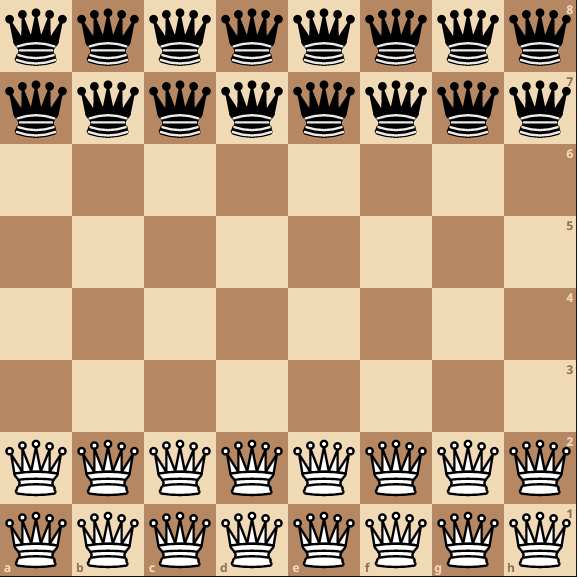

This is the question mathematicians and chess grandmasters have asked themselves since the 19th century when it was first proposed by Max Friedrich William Bezzel in 1848. Since then, it has been recognized as A good problem for algorithm developers to challenge themselves on and there have been many attempts to craft solvers. Methods such as recursion, backtracking, and machine learning have been used and result in solutions in the case of brute force methods and or a probability of a solution in other heuristic solvers.
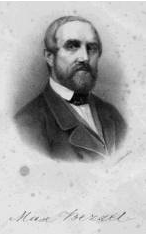
#### Max Bezzel

    What does that mean exactly? While some methods at finding this solution resort to many attempts at the puzzle and will only move forward with their solution or state that a solution has been found when all possible permutations to the problem have been tried. These are brute force solutions, and their name is a reference to their brutish and unrefined method of solving a problem. Sometimes a more elegant approach is used but there are tradeoffs, these solvers may use shrunken problem spaces or translations to different representations of the problem to generate a solution. These solvers called heuristic solvers may or may not produce a solution to your problem depending on how the algorithm was designed. Their advantage is they can have time and computation savings when solving a problem because they are not trying every solution to solve the problem.

## Problem lab description
Currently the largest board for which all solutions have been found is 27 queens on a 27x27 board ((Preußer,2016) and academic works state that this is a NP-complete problem that can be solved in polynomial time but the current best on a classical computer is factorial O(N!). What if we were to use a quantum computer to solve the problem?

Your task for this lab will be to design a circuit to solve the n-queens problem on a 3x3 board or larger. There are no limits on the design of the circuit,however you may not be able to run it on a quantum simulator. I will provide you with some code to guide you towards a solution design. Please see the provided functions below.

## Solution description
You will provide as a solution a histograph displaying the readouts of a quantum circuit where the solution(s) of the n-queens question is displayed in the histogram. 


[1] - [A Novel Quantum N-Queens Solver Algorithm and its Simulation and Application to
Satellite Communication Using IBM Quantum Experience](https://arxiv.org/pdf/1806.10221.pdf)

In [4]:
def verticle(period):
    pairs_list = []
    x = period
    if x <= boardsize:
        d = x
        for c in range(boardsize-1):
            d = d + boardsize
            pairs_list.append([x,d])
    # middle rows
    elif x > boardsize and x <= (boardsize*(boardsize - 1)):
        d = x
        while d > 0:
            d = d - boardsize
            if d > 0:
                pairs_list.append([x,d])
        d = x
        while d < (boardsize*boardsize): 
            d = d + boardsize
            if d <= (boardsize*boardsize):
                pairs_list.append([x,d])
    # bottom row
    elif x > (boardsize*(boardsize - 1)) and x <= (boardsize*boardsize):
        d = x
        for c in range(boardsize-1):
            d = d - boardsize
            pairs_list.append([x,d])
    
    return pairs_list

def horizontal(period):
    pairs_list = []
    e = boardsize
    p = False
    while p != True:
        if e >= period:
            d = (e-(boardsize-1))
            if d != period:
                pairs_list.append([period,d])
            for x in range(boardsize-1):
                d += 1
                if d != period and d <= e:
                    pairs_list.append([period,d])
            p = True
        e += boardsize
    return pairs_list

def diag(period):
    pairs_list = []
    e = boardsize
    p = False
    while p != True:
        if e >= period:
            a = e
            b = e-(boardsize-1)
            p = True
        e += boardsize
    z = period
    v = b - boardsize
    g = a - boardsize
    y = (z - boardsize) + 1
    q = (z - boardsize) - 1
    while q >= v or y <= g:
        if y <= g and y >= boardsize-(boardsize-1):
            pairs_list.append([period,y])
        if q >= v and q >= boardsize-(boardsize-1):
            pairs_list.append([period,q])
        
        #get the bounds of the row
        v = v - boardsize
        g = g - boardsize
        y = (y - boardsize) + 1
        q = (q - boardsize) - 1
        
    v = b + boardsize
    g = a + boardsize
    y = (z + boardsize) + 1
    q = (z + boardsize) - 1
    while q >= v or y <= g:
        
        if y <= g and y <= boardsize*boardsize:
            pairs_list.append([period,y])
        if q >= v and q <= boardsize*boardsize:
            pairs_list.append([period,q])
        #get the bounds of the row
        v = v + boardsize
        g = g + boardsize
        y = (y + boardsize) + 1
        q = (q + boardsize) - 1
    return pairs_list


def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return 
def binary_conv(x):
    binary = []
    binary_2 = []
    for binary_num in range(4+1):
        if x - 2**(4-binary_num) >= 0:
            x -= 2**(4-binary_num)
            binary.append(1)
        elif x- 2**(4-binary_num) < 0:
            binary.append(0)
    for counter in range(5):
        binary_2.append(binary[(4)-counter])
    binary = binary_2
    
    return binary

def binary_gates(x):
    cir_list = []
    binary = binary_conv(x)
    
    for pu in range(5):
        if binary[pu] == 1:
            circuit.cx(qreg_s[0], qreg_h[pu])
            cir_list.append(qreg_h[pu])
    if cir_list:
        cir_list.append(qreg_s[0])
    circuit.mct(cir_list, qreg_a)
    for pu in range(5):
        if binary[pu] == 1:
            circuit.cx(qreg_s[0], qreg_h[pu])

In [5]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

qreg_q = QuantumRegister(25, 'q')
creg_c = ClassicalRegister(25, 'c')
circuit = QuantumCircuit(qreg_q,creg_c)

plot_histogram(result.get_counts(), figsize=(14,14), sort='desc', number_to_keep=20)

Traceback (most recent call last):
  Input In [5] in <cell line: 8>
    plot_histogram(result.get_counts(), figsize=(14,14), sort='desc', number_to_keep=20)
NameError: name 'result' is not defined

Use %tb to get the full traceback.
